In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from fbprophet import Prophet

%matplotlib inline

In [99]:
plt.style.use('ggplot')

In [13]:
data = pd.read_csv('cellphonedata.csv')
data['date'] = pd.to_datetime(data['date'])

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896 entries, 0 to 3895
Data columns (total 8 columns):
date                 3896 non-null datetime64[ns]
price_category       3896 non-null object
offer                3896 non-null float64
price                3896 non-null float64
freight_value        3896 non-null float64
competition_price    3896 non-null float64
stock                3896 non-null float64
orders               3896 non-null float64
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 243.6+ KB


In [15]:
data.head()

,date,price_category,offer,price,freight_value,competition_price,stock,orders
0,2017-06-30,A,165.900000,165.900000,20.0,165.900000,0.0,0.0
1,2017-06-30,B,455.015000,455.015000,24.0,455.015000,0.0,0.0
2,2017-06-30,C,931.184286,931.184286,31.0,931.184286,0.0,0.0
3,2017-06-30,D,3522.147143,3522.147143,39.0,3522.147143,0.0,0.0
4,2017-07-01,A,165.900000,165.900000,20.0,165.900000,30.0,0.0


In [55]:
df_a = data[data['price_category']=='A'].copy().reset_index(drop=True)
df_b = data[data['price_category']=='B'].copy().reset_index(drop=True)
df_c = data[data['price_category']=='C'].copy().reset_index(drop=True)
df_d = data[data['price_category']=='D'].copy().reset_index(drop=True)

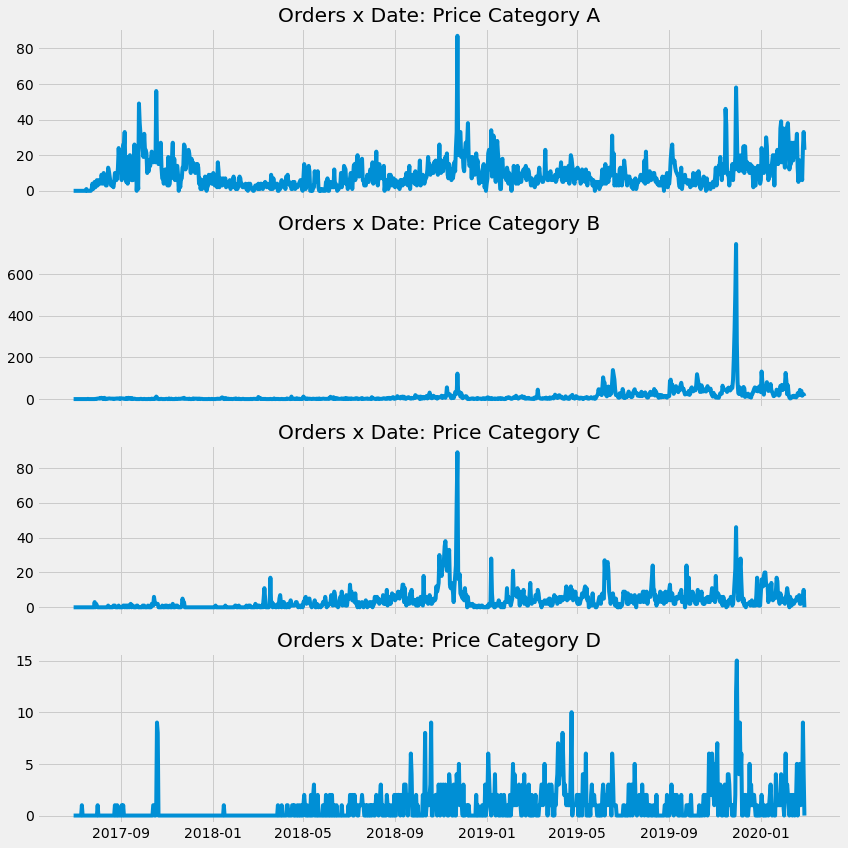

In [56]:
fig, ax = plt.subplots(nrows=4, figsize=(12,12), sharex=True)

ax[0].plot('date', 'orders', data=df_a)
ax[1].plot('date', 'orders', data=df_b)
ax[2].plot('date', 'orders', data=df_c)
ax[3].plot('date', 'orders', data=df_d)

ax[0].set_title('Orders x Date: Price Category A')
ax[1].set_title('Orders x Date: Price Category B')
ax[2].set_title('Orders x Date: Price Category C')
ax[3].set_title('Orders x Date: Price Category D')

plt.tight_layout()
plt.show()

In [28]:
# def lagged_variables(df, lags=10):
#     for lag in range(1,lags+1):
#         df['lag-'+str(lag)] = df['orders'].shift(lag)
#     return df.dropna(inplace=True)

# for df in [df_a, df_b, df_c, df_d]:
#     df = lagged_variables(df, lags=10)

In [57]:
df_a.head()

,date,price_category,offer,price,freight_value,competition_price,stock,orders
0,2017-06-30,A,165.9,165.9,20.0,165.9,0.0,0.0
1,2017-07-01,A,165.9,165.9,20.0,165.9,30.0,0.0
2,2017-07-02,A,165.9,165.9,20.0,165.9,50.0,0.0
3,2017-07-03,A,165.9,165.9,20.0,165.9,50.0,0.0
4,2017-07-04,A,165.9,165.9,20.0,165.9,50.0,0.0


## Holidays

In [58]:
def get_holidays():
    """
    Get Black Friday dates
    """
    black_friday = pd.DataFrame({
                  'holiday': 'black_friday',
                  'ds': pd.to_datetime(['2017-11-24', '2018-11-23', '2019-11-29',
                                        '2020-11-27', '2021-11-26', '2022-11-25',
                                        '2023-11-24', '2024-11-29', '2025-11-28']),
                  'lower_window': -3,
                  'upper_window': 3,
                })

    xmas = pd.DataFrame({
                  'holiday': 'christmas',
                  'ds': pd.to_datetime(['2017-12-25', '2018-12-25', '2019-12-25',
                                        '2020-12-25', '2021-12-25', '2022-12-25',
                                        '2023-12-25', '2024-12-25', '2025-12-25']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    new_year = pd.DataFrame({
                  'holiday': 'new_year',
                  'ds': pd.to_datetime(['2017-01-01', '2018-01-01', '2019-01-01',
                                        '2020-01-01', '2021-01-01', '2022-01-01',
                                        '2023-01-01', '2024-01-01', '2025-01-01']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    carnival = pd.DataFrame({
                  'holiday': 'carnival',
                  'ds': pd.to_datetime(['2017-02-28', '2018-02-13', '2019-03-05',
                                        '2020-02-25', '2021-02-16', '2022-03-01',
                                        '2023-02-21', '2024-02-13', '2025-03-04']),
                  'lower_window': -1,
                  'upper_window': 0,
                })

    good_friday = pd.DataFrame({
                  'holiday': 'good_friday',
                  'ds': pd.to_datetime(['2018-03-18','2019-04-19','2020-04-10',
                                        '2021-04-02','2022-04-15','2023-04-07',
                                        '2024-03-29']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    valentines = pd.DataFrame({
                  'holiday': 'valentines',
                  'ds': pd.to_datetime(['2016-06-12','2017-06-12','2018-06-12',
                                        '2019-06-12','2020-06-12','2021-06-12']),
                  'lower_window': -7,
                  'upper_window': 0,
                })
    
    mothers_day = pd.DataFrame({
                  'holiday': 'mothers_day',
                  'ds': pd.to_datetime(['2018-05-13','2019-05-12']),
                  'lower_window': -7,
                  'upper_window': 0,
                })
    # long holidays

    monday = pd.DataFrame({
                  'holiday': 'monday',
                  'ds': pd.to_datetime(['2020-09-07','2020-10-12','2020-11-02',
                                        '2021-11-15']),
                  'lower_window': -2,
                  'upper_window': 0,
                })

    friday = pd.DataFrame({
                  'holiday': 'friday',
                  'ds': pd.to_datetime(['2018-09-07','2018-10-12','2018-11-02',
                                        '2019-11-15','2020-05-01']),
                  'lower_window': 0,
                  'upper_window': 2,
                })

    # Different cases
    # 2019-12-30 (christmas and New year's eve from tuesday to wednesday. Monday was also affected)
    others = pd.DataFrame({
                  'holiday': 'others',
                  'ds': pd.to_datetime(['2019-12-23','2019-12-30']),
                  'lower_window': 0,
                  'upper_window': 0,
                })

    holidays = pd.concat((black_friday, xmas, new_year, carnival, valentines, mothers_day,
                         monday, friday, others))

    return holidays

In [59]:
# get holidays dataframe
holidays = get_holidays()

# transform holidays
hday=[]
hdate=[]
for row in holidays.itertuples():
    lower = row.lower_window
    upper = row.upper_window
    holiday  = row.holiday
    day = row.ds
    
    for i in range(lower, upper+1):
        hday.append(holiday)
        hdate.append(day + timedelta(days=i))
        
hdays = pd.DataFrame(zip(hday,hdate), columns=['holiday','date'])

# Final dataset

In [60]:
df = df_b.copy()

df = pd.merge(df, hdays, left_on='date', right_on='date', how='left')

# one-hot encode holidays
one_hot = pd.get_dummies(data=df['holiday'], dummy_na=True)
# drop nan col (will serve to avoid multicollinearity)
one_hot.drop(columns=[np.nan], inplace=True)

# drop holiday columns
df.drop(columns=['holiday'], inplace=True)

# Join df with one-hot
df = df.join(one_hot)

# get date parameters
df['year']      = df['date'].apply(lambda x: x.year)
df['month']     = df['date'].apply(lambda x: x.month)
df['dayofweek'] = df['date'].apply(lambda x: x.dayofweek)
df['day']       = df['date'].apply(lambda x: x.day)

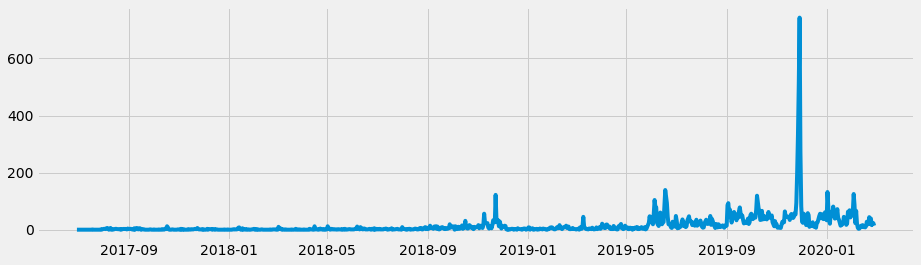

In [61]:
plt.figure(figsize=(14,4))
plt.plot('date','orders', data=df)

# Preprocessing

### Train test split

In [93]:
# cut to include black friday in training set
split_point = round(df.shape[0] * 0.92)

train = df.iloc[:split_point].drop(columns=['date','price_category'])
test  = df.iloc[split_point:].drop(columns=['date','price_category'])

X_train, y_train = train.drop(columns=['orders']).values, train['orders'].values
X_test, y_test = test.drop(columns=['orders']).values, test['orders'].values

In [94]:
print("training set shape: ", train.shape)
print("test set shape: ", test.shape)
print()
print("X_train shape: {}        y_train shape: {}".format(X_train.shape,y_train.shape))
print(" y_test shape: {}         y_test shape:  {}".format(X_test.shape,y_test.shape))

training set shape:  (896, 18)
test set shape:  (78, 18)

X_train shape: (896, 17)        y_train shape: (896,)
 y_test shape: (78, 17)         y_test shape:  (78,)


### Scaling (optional)

In [67]:
from sklearn.preprocessing import StandardScaler

scaling_enabled = False

if scaling_enabled:
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train.values)
    X_test  = scaler.transform(y_test.values)
    
    y_train = scaler.fit_transform(y_train.values)
    y_test  = scaler.transform(y_test.values)

# Metrics: MAE and RMSE

In [81]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

scores = {}

## Baseline Models

#### y = 0

In [95]:
mae_train  = mean_absolute_error(y_train, np.zeros(y_train.shape))
rmse_train = np.sqrt(mean_squared_error(y_train, np.zeros(y_train.shape))) 

mae_test   = mean_absolute_error(y_test, np.zeros(y_test.shape))
rmse_test  = np.sqrt(mean_squared_error(y_test, np.zeros(y_test.shape)))

scores['baseline_zero'] = {'mae': (mae_train, mae_test), 
                           'rmse':(rmse_train, rmse_test)}

print(scores['baseline_zero'])

{'mae': (12.904017857142858, 36.55128205128205), 'rmse': (40.0131953681711, 44.423803967854425)}


#### y = mean(y_train)

In [96]:
# only use mean of y_train to avoid look-ahead bias
mean = np.mean(y_train)
train_pred = np.ones(y_train.shape)*mean
test_pred = np.ones(y_test.shape)*mean

mae_train  = mean_absolute_error(y_train, train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred)) 

mae_test   = mean_absolute_error(y_test, test_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_pred))

scores['baseline_mean'] = {'mae': (mae_train, mae_test), 
                           'rmse':(rmse_train, rmse_test)}

print(scores['baseline_mean'])

{'mae': (15.32667012117347, 24.97670558608058), 'rmse': (37.875349855994294, 34.59293632014205)}


## Linear Regression

In [97]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# can't be negative
y_pred[y_pred < 0] = 0

mae_test   = mean_absolute_error(y_test, y_pred)
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred))

scores['LinearRegression'] = {'mae':mae_test, 
                              'rmse':rmse_test}

print(scores['LinearRegression'])

{'mae': 28.05116651516353, 'rmse': 38.57572892535668}


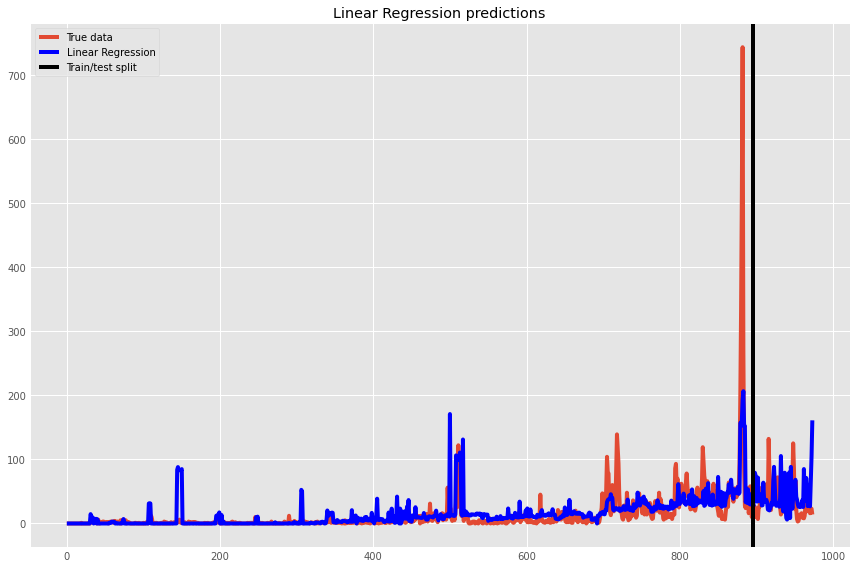

In [105]:
# Plotting

# recreate model (y = b + a*x) training data
lr = model.intercept_ + np.dot(X_train, model.coef_)
lr[lr < 0 ] = 0


fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df.orders.values, label='True data')
ax.plot(np.append(lr, y_pred), color='blue', label='Linear Regression')
plt.axvline(x=split_point, color='black', label='Train/test split')
ax.set_title("Linear Regression predictions")

plt.legend()

plt.tight_layout()
plt.show()

## Decision Trees

## Random Forests

## SVM

## XGBoost

In [143]:
import xgboost as xgb

xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test  = xgb.DMatrix(X_test, label=y_test)

# Hyperparameters
param = {
    'max_depth':5,
    'eta':0.01,
    'objective': 'reg:squarederror',
    'eval_metric': ['mae', 'rmse'],
    'lambda':1.2
}
epochs = 1000

model = xgb.train(param, xgb_train, epochs)
train_predictions = model.predict(xgb_train)
train_predictions[train_predictions < 0] = 0
test_predictions  = model.predict(xgb_test)
test_predictions[test_predictions < 0] = 0

mae_test   = mean_absolute_error(y_test, test_predictions)
rmse_test  = np.sqrt(mean_squared_error(y_test, test_predictions))

scores['XGBoost'] = {'mae': mae_test, 
                     'rmse':rmse_test}

print(scores['XGBoost'])

{'mae': 27.577072957769417, 'rmse': 37.92819836709707}


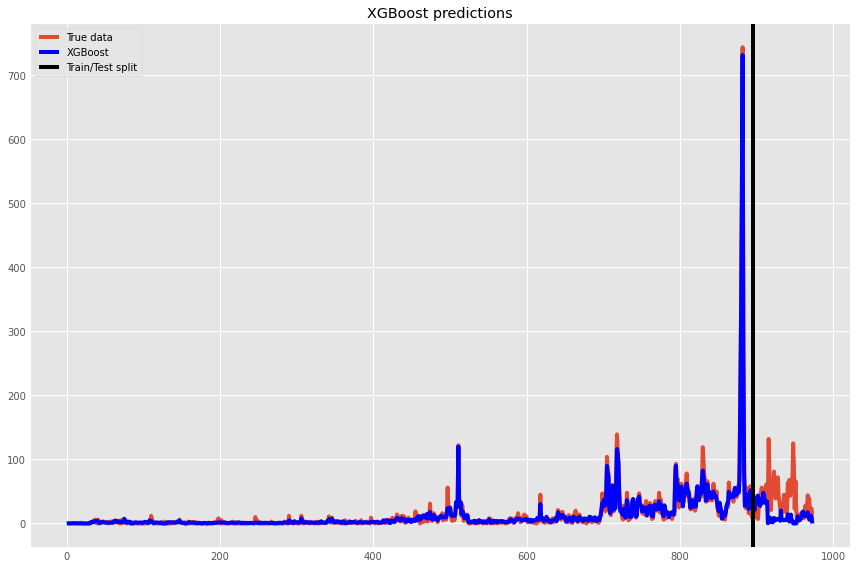

In [144]:
# Plotting
xgb_predictions = np.append(train_predictions, test_predictions)

fig, ax = plt.subplots(figsize=(12,8))

## True values
ax.plot(df.orders.values, label='True data')
ax.plot(xgb_predictions, color='blue', label='XGBoost')
plt.axvline(x=split_point, color='black', label='Train/Test split')
ax.set_title("XGBoost predictions")

plt.legend()

plt.tight_layout()
plt.show()